## Machine learning modeling - best model visualization

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.options.display.max_rows = 999

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil
import jenkspy
import statsmodels
import statsmodels.api as sm

# ml modules
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.utils import resample

In [104]:
# read in 990 data that has been
# subsetted and cleaned in 990_cont_comp_EDA notebook
df = pd.read_csv('data/990_model_data_3.csv')

In [19]:
df.shape

(26881, 28)

In [20]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,1000243.0,173898488.0,88052685.0,16354368.0,1262299,188534687,90509772,17619471,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978,21,19,53,200.0,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298,8,7,442,15.0,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176,12,12,139,50.0,2437,0.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


In [116]:
# create features for classification
# while removing those I created in designing
# my target variable
X = pd.get_dummies(df).drop(['TARGET_FEATURE',
            'CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            'volunteer_tot_ct',
            'employee_tot_ct',
            'contractor_100k_ct'], axis=1)

# create target for classification
y = df.TARGET_FEATURE

In [117]:
X.shape

(26881, 38)

In [118]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
X.shape

(26881, 38)

<a id="gradient_boost_classifier"></a>

### Gradient Boost Classifier

In [119]:
# fit model based on grid search parameters
params = {'n_estimators': 950,
          'max_depth': 2,
          'subsample': .8,
          'learning_rate': .1,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=950,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [120]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.004417782738095238
Percent Type II errors: 0.08393787202380952

Test set accuracy:
Percent Type I errors: 0.012832434442997954
Percent Type II errors: 0.08480565371024736


In [27]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19067,77
Actual: Yes,1844,516


In [28]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4764,64
Actual: Yes,463,86


Gradient Boost Classifier did a much better job of predicting Yes

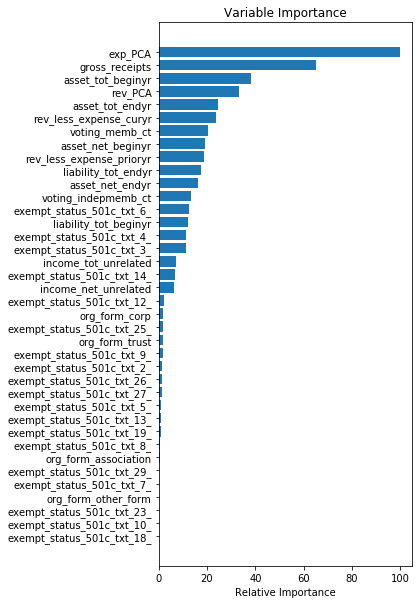

In [29]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (clf.feature_importances_ / clf.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

In [30]:
# find insignificant features
clf_features = pd.DataFrame(clf.feature_importances_,
            X.columns, columns=['importance'])

clf_features[(clf_features < .004).iloc[:,0]].index

Index(['org_form_corp', 'org_form_trust', 'org_form_association',
       'org_form_other_form', 'exempt_status_501c_txt_10_',
       'exempt_status_501c_txt_13_', 'exempt_status_501c_txt_18_',
       'exempt_status_501c_txt_19_', 'exempt_status_501c_txt_23_',
       'exempt_status_501c_txt_25_', 'exempt_status_501c_txt_26_',
       'exempt_status_501c_txt_27_', 'exempt_status_501c_txt_29_',
       'exempt_status_501c_txt_2_', 'exempt_status_501c_txt_5_',
       'exempt_status_501c_txt_7_', 'exempt_status_501c_txt_8_',
       'exempt_status_501c_txt_9_'],
      dtype='object')

In [31]:
# examine how model flagged specific orgs
# concatenate X, y, and predictions
pd.concat([X, pd.DataFrame(predict_test), y], axis=1)[(pd.concat([X, pd.DataFrame(predict_test), y], axis=1).loc[:,0] == True) &
                                                     (pd.concat([X, pd.DataFrame(predict_test), y], axis=1).loc[:,'TARGET_FEATURE'] == True)].head(10)

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,gross_receipts,voting_memb_ct,voting_indepmemb_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,rev_PCA,exp_PCA,exempt_status_501c_txt_10_,exempt_status_501c_txt_12_,exempt_status_501c_txt_13_,exempt_status_501c_txt_14_,exempt_status_501c_txt_18_,exempt_status_501c_txt_19_,exempt_status_501c_txt_23_,exempt_status_501c_txt_25_,exempt_status_501c_txt_26_,exempt_status_501c_txt_27_,exempt_status_501c_txt_29_,exempt_status_501c_txt_2_,exempt_status_501c_txt_3_,exempt_status_501c_txt_4_,exempt_status_501c_txt_5_,exempt_status_501c_txt_6_,exempt_status_501c_txt_7_,exempt_status_501c_txt_8_,exempt_status_501c_txt_9_,0,TARGET_FEATURE
319,True,False,False,False,535136,18,18,0,0.0,337113.0,787062.0,13131.0,773931.0,-124720,660240,6999,653241,-1.227172e+08,-1.040853e+08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
444,True,False,False,False,50049226,14,14,0,0.0,675468.0,9600399.0,7235574.0,2364825.0,-447863,9368712,7451750,1916962,-6.939333e+07,-2.137556e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
514,True,False,False,False,90364007,13,8,199189,0.0,4893332.0,208296489.0,88052685.0,111411930.0,5845962,213866541,90509772,114142023,-6.873379e+06,-1.073917e+07,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,True
1345,True,False,False,False,1291055,23,23,0,0.0,183243.0,1179362.0,234022.0,945340.0,20843,1202521,236338,966183,-1.207786e+08,-1.027279e+08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,True,True
2435,True,False,False,False,13693087,8,3,0,0.0,34076.0,9584839.0,15888046.0,-6303207.0,5845962,0,0,0,-1.111906e+08,-9.267509e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
2949,True,False,False,False,4416675,10,4,199189,0.0,314080.0,6127797.0,712952.0,5414845.0,676566,6511295,532898,5978397,-1.158456e+08,-9.855986e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
3317,True,False,False,False,2616566,28,28,0,0.0,12608.0,1286768.0,103115.0,1183653.0,-44581,1265328,126256,1139072,-1.184896e+08,-1.002810e+08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True
4222,True,False,False,False,545736,14,14,0,0.0,-5086.0,555539.0,502085.0,53454.0,5727,543290,483162,60128,-1.223380e+08,-1.041184e+08,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True
4444,True,False,False,False,1345000,1,1,0,0.0,70253.0,74187.0,30000.0,44187.0,28734,102919,30000,72919,-1.224723e+08,-1.038189e+08,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True
4556,True,False,False,False,1388311,3,2,0,0.0,-78880.0,16901641.0,17597285.0,-695644.0,141317,17020598,17574926,-554328,-1.209037e+08,-1.027082e+08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,True,True


### Visualizations examining classification results

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
predict_test = clf.predict(X)

In [87]:
y.to_frame().head()

,TARGET_FEATURE
0,False
1,False
2,False
3,False
4,False


In [96]:
y.to_frame().rename(columns={"TARGET_FEATURE": "pred"}).head()

,pred
0,False
1,False
2,False
3,False
4,False


In [138]:
df_with_pred = pd.concat([df.iloc[y_test.index], y_test.to_frame().rename(columns={"TARGET_FEATURE": "pred"})], axis=1)

In [139]:
df_with_pred.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA,pred
18813,True,False,False,False,4_,7.942360e+05,8,8,6,0.0,0.0,0.0,54831.0,9.520641e+06,4.044151e+06,5476490.0,21611.0,8.810439e+06,3.312338e+06,5498101.0,1,0.166667,0.264980,True,False,False,-1.215951e+08,-1.036099e+08,False
2161,True,False,False,False,3_,1.198234e+09,32,27,5285,0.0,5503201.2,0.0,85464866.4,2.007782e+09,1.082905e+09,787226494.0,-218377154.0,2.072073e+09,1.169530e+09,670919531.0,167,0.054683,4.087313,False,True,False,1.871040e+09,1.549296e+09,False
5453,True,False,False,False,3_,5.658511e+08,18,16,2398,17.0,2711626.0,268200.0,19599023.0,1.306178e+09,1.082905e+09,155893581.0,21424590.0,1.600675e+09,1.146370e+09,454305205.0,134,0.055487,1.371334,False,True,False,8.282147e+08,6.544436e+08,False
19697,True,False,False,False,3_,4.487151e+06,12,12,27,695.0,0.0,0.0,-207311.0,3.541433e+06,1.565050e+05,3384928.0,-158900.0,3.557726e+06,3.316980e+05,3226028.0,2,0.002770,0.160454,False,False,False,-1.201244e+08,-1.006969e+08,False
20822,True,False,False,False,3_,2.327829e+07,5,5,262,26.0,31384.0,28985.0,-3080310.0,1.364939e+07,2.544957e+07,-11800186.0,-1802817.0,1.295637e+07,2.797893e+07,-15022559.0,5,0.017361,0.089615,False,False,False,-7.877878e+07,-6.356010e+07,False


In [128]:
df.iloc[y_test.index].head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
18813,True,False,False,False,4_,7.942360e+05,8,8,6,0.0,0.0,0.0,54831.0,9.520641e+06,4.044151e+06,5476490.0,21611.0,8.810439e+06,3.312338e+06,5498101.0,1,0.166667,0.264980,True,False,False,-1.215951e+08,-1.036099e+08
2161,True,False,False,False,3_,1.198234e+09,32,27,5285,0.0,5503201.2,0.0,85464866.4,2.007782e+09,1.082905e+09,787226494.0,-218377154.0,2.072073e+09,1.169530e+09,670919531.0,167,0.054683,4.087313,False,True,False,1.871040e+09,1.549296e+09
5453,True,False,False,False,3_,5.658511e+08,18,16,2398,17.0,2711626.0,268200.0,19599023.0,1.306178e+09,1.082905e+09,155893581.0,21424590.0,1.600675e+09,1.146370e+09,454305205.0,134,0.055487,1.371334,False,True,False,8.282147e+08,6.544436e+08
19697,True,False,False,False,3_,4.487151e+06,12,12,27,695.0,0.0,0.0,-207311.0,3.541433e+06,1.565050e+05,3384928.0,-158900.0,3.557726e+06,3.316980e+05,3226028.0,2,0.002770,0.160454,False,False,False,-1.201244e+08,-1.006969e+08
20822,True,False,False,False,3_,2.327829e+07,5,5,262,26.0,31384.0,28985.0,-3080310.0,1.364939e+07,2.544957e+07,-11800186.0,-1802817.0,1.295637e+07,2.797893e+07,-15022559.0,5,0.017361,0.089615,False,False,False,-7.877878e+07,-6.356010e+07


In [124]:
y_test.head().to_frame()

,TARGET_FEATURE
18813,False
2161,False
5453,False
19697,False
20822,False


In [121]:
X_test.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,gross_receipts,voting_memb_ct,voting_indepmemb_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,rev_PCA,exp_PCA,exempt_status_501c_txt_10_,exempt_status_501c_txt_12_,exempt_status_501c_txt_13_,exempt_status_501c_txt_14_,exempt_status_501c_txt_18_,exempt_status_501c_txt_19_,exempt_status_501c_txt_23_,exempt_status_501c_txt_25_,exempt_status_501c_txt_26_,exempt_status_501c_txt_27_,exempt_status_501c_txt_29_,exempt_status_501c_txt_2_,exempt_status_501c_txt_3_,exempt_status_501c_txt_4_,exempt_status_501c_txt_5_,exempt_status_501c_txt_6_,exempt_status_501c_txt_7_,exempt_status_501c_txt_8_,exempt_status_501c_txt_9_
18813,True,False,False,False,7.942360e+05,8,8,0.0,0.0,54831.0,9.520641e+06,4.044151e+06,5476490.0,21611.0,8.810439e+06,3.312338e+06,5498101.0,-1.215951e+08,-1.036099e+08,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2161,True,False,False,False,1.198234e+09,32,27,5503201.2,0.0,85464866.4,2.007782e+09,1.082905e+09,787226494.0,-218377154.0,2.072073e+09,1.169530e+09,670919531.0,1.871040e+09,1.549296e+09,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5453,True,False,False,False,5.658511e+08,18,16,2711626.0,268200.0,19599023.0,1.306178e+09,1.082905e+09,155893581.0,21424590.0,1.600675e+09,1.146370e+09,454305205.0,8.282147e+08,6.544436e+08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
19697,True,False,False,False,4.487151e+06,12,12,0.0,0.0,-207311.0,3.541433e+06,1.565050e+05,3384928.0,-158900.0,3.557726e+06,3.316980e+05,3226028.0,-1.201244e+08,-1.006969e+08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
20822,True,False,False,False,2.327829e+07,5,5,31384.0,28985.0,-3080310.0,1.364939e+07,2.544957e+07,-11800186.0,-1802817.0,1.295637e+07,2.797893e+07,-15022559.0,-7.877878e+07,-6.356010e+07,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [107]:
df_with_pred = pd.concat([df, y.to_frame().rename(columns={"TARGET_FEATURE": "pred"}).head()], axis=1)

In [98]:
df_with_pred.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA,pred
0,True,False,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07,False
1,True,False,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,1000243.0,173898488.0,88052685.0,16354368.0,1262299,188534687,90509772,17619471,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07,False
2,True,False,False,False,5_,8503978,21,19,53,200.0,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07,False
3,True,False,False,False,3_,57422298,8,7,442,15.0,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07,False
4,True,False,False,False,7_,5974176,12,12,139,50.0,2437,0.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07,False


In [136]:
df_with_pred.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA,TARGET_FEATURE
18813,True,False,False,False,4_,7.942360e+05,8,8,6,0.0,0.0,0.0,54831.0,9.520641e+06,4.044151e+06,5476490.0,21611.0,8.810439e+06,3.312338e+06,5498101.0,1,0.166667,0.264980,True,False,False,-1.215951e+08,-1.036099e+08,False
2161,True,False,False,False,3_,1.198234e+09,32,27,5285,0.0,5503201.2,0.0,85464866.4,2.007782e+09,1.082905e+09,787226494.0,-218377154.0,2.072073e+09,1.169530e+09,670919531.0,167,0.054683,4.087313,False,True,False,1.871040e+09,1.549296e+09,False
5453,True,False,False,False,3_,5.658511e+08,18,16,2398,17.0,2711626.0,268200.0,19599023.0,1.306178e+09,1.082905e+09,155893581.0,21424590.0,1.600675e+09,1.146370e+09,454305205.0,134,0.055487,1.371334,False,True,False,8.282147e+08,6.544436e+08,False
19697,True,False,False,False,3_,4.487151e+06,12,12,27,695.0,0.0,0.0,-207311.0,3.541433e+06,1.565050e+05,3384928.0,-158900.0,3.557726e+06,3.316980e+05,3226028.0,2,0.002770,0.160454,False,False,False,-1.201244e+08,-1.006969e+08,False
20822,True,False,False,False,3_,2.327829e+07,5,5,262,26.0,31384.0,28985.0,-3080310.0,1.364939e+07,2.544957e+07,-11800186.0,-1802817.0,1.295637e+07,2.797893e+07,-15022559.0,5,0.017361,0.089615,False,False,False,-7.877878e+07,-6.356010e+07,False


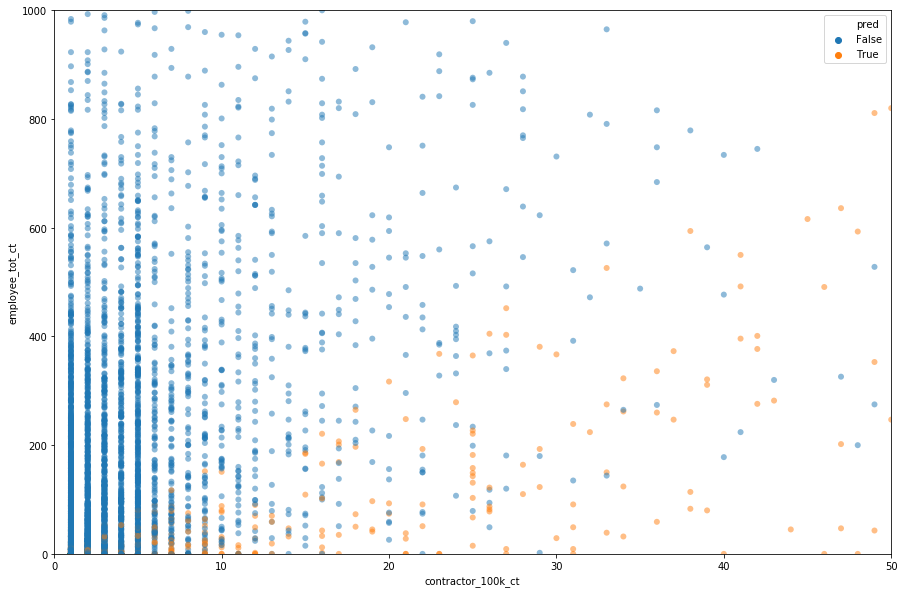

In [149]:
fig = plt.figure(figsize=(15, 10))

sns.scatterplot(x=df_with_pred.contractor_100k_ct, 
                y=df_with_pred.employee_tot_ct, 
                color='brown', 
                alpha=.5, 
                edgecolor="none",
               hue=df_with_pred.pred)

plt.xlim(0, 50)
plt.ylim(0, 1000);

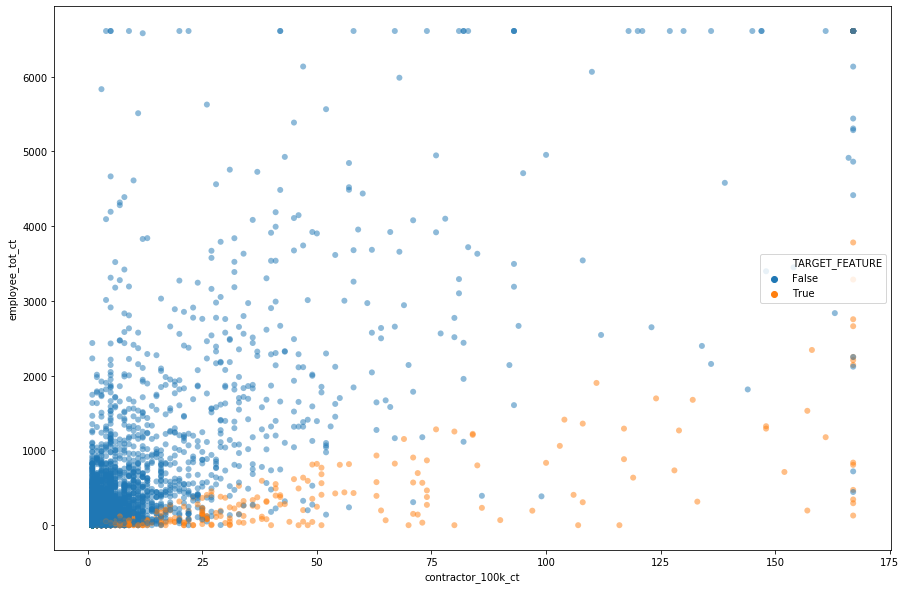

In [147]:
fig = plt.figure(figsize=(15, 10))

sns.scatterplot(x=df_with_pred.contractor_100k_ct, 
                y=df_with_pred.employee_tot_ct, 
                color='brown', 
                alpha=.5, 
                edgecolor="none",
               hue=df_with_pred.TARGET_FEATURE);

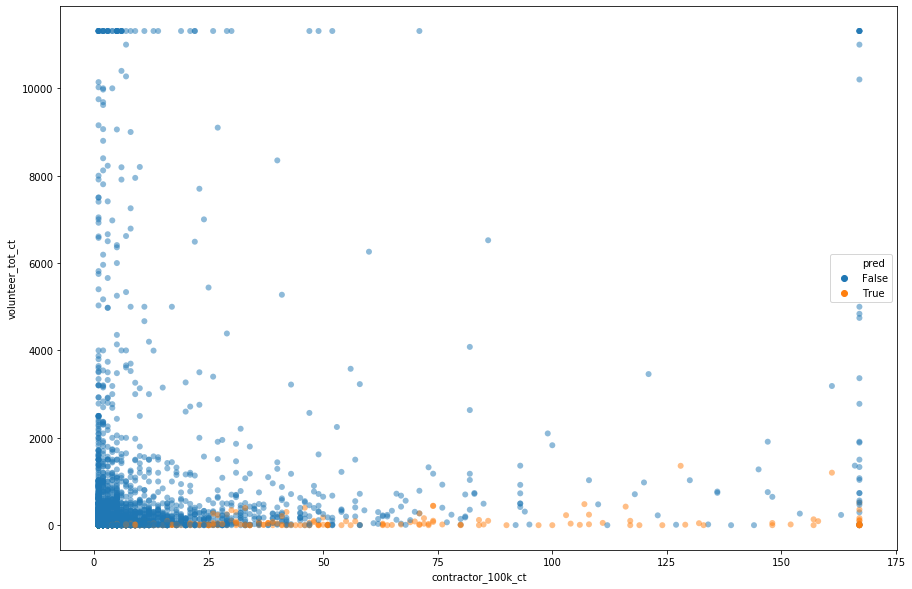

In [143]:
fig = plt.figure(figsize=(15, 10))

sns.scatterplot(x=df_with_pred.contractor_100k_ct, 
                y=df_with_pred.volunteer_tot_ct, 
                color='brown', 
                alpha=.5, 
                edgecolor="none",
               hue=df_with_pred.pred);

### Gross Receipts

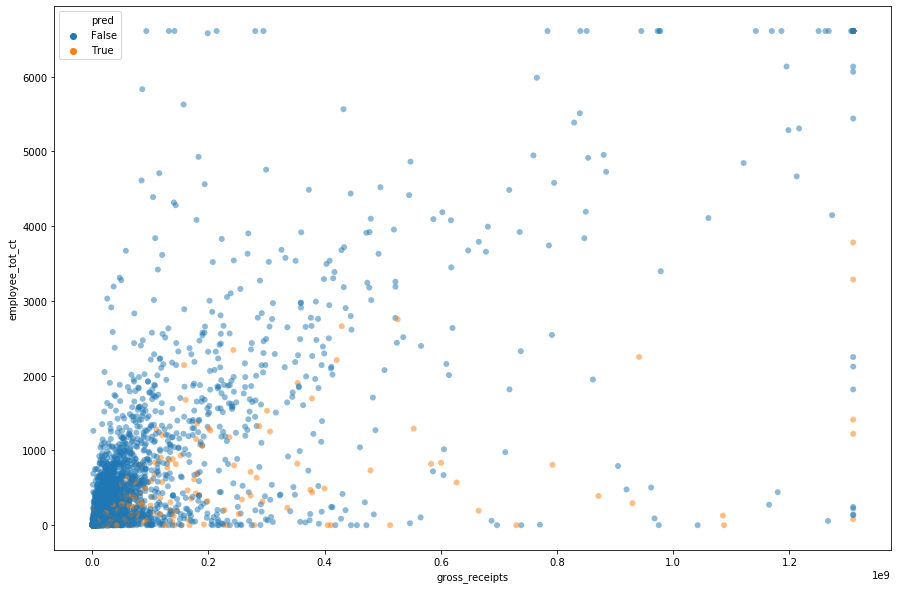

In [144]:
fig = plt.figure(figsize=(15, 10))

sns.scatterplot(x=df_with_pred.gross_receipts, 
                y=df_with_pred.employee_tot_ct, 
                color='brown', 
                alpha=.5, 
                edgecolor="none",
               hue=df_with_pred.pred);

In [151]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792.0,11,11,37,0.0,0.0,0.0,0.0,39372255.0,26541056.0,12831199.0,0.0,39367859.0,26785093.0,12582766.0,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036.0,9,8,81,8.0,52565.0,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299.0,188534687.0,170915216.0,17619471.0,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978.0,21,19,53,200.0,16110.0,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972.0,3640881.0,852359.0,2788522.0,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298.0,8,7,442,15.0,0.0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630.0,56726534.0,12198910.0,44527624.0,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176.0,12,12,139,50.0,2437.0,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724.0,10535130.0,3089889.0,7445241.0,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


In [161]:
df_with_pred.loc[df_with_pred.CON_CT_DIV_EMP_VOL_CT_flag == True, 'contractor_100k_ct'].head()

18813     1
5322      4
15269    23
17388     3
21897     1
Name: contractor_100k_ct, dtype: int64

In [160]:
df_with_pred.loc[df_with_pred.CON_CT_DIV_EMP_VOL_CT_flag == True, 'employee_tot_ct'].head()

18813     6
5322     46
15269     0
17388    11
21897     0
Name: employee_tot_ct, dtype: int64

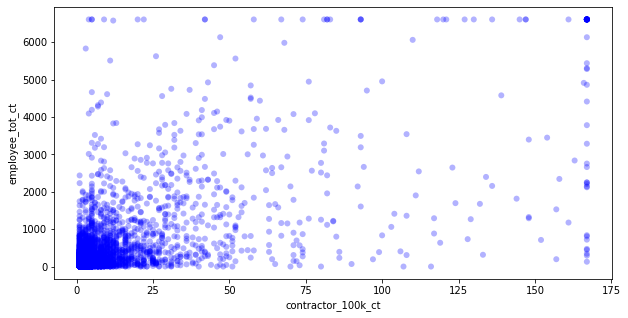

In [179]:
fig = plt.figure(figsize=(10, 5))

sns.scatterplot(df_with_pred.contractor_100k_ct,
           df_with_pred.employee_tot_ct,
           color='blue',
           alpha=.3,
           edgecolor="none");

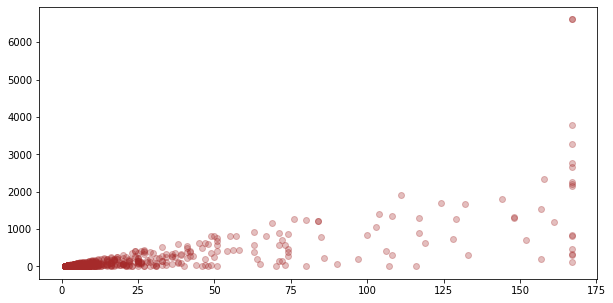

In [172]:
fig = plt.figure(figsize=(10, 5))

plt.scatter(df_with_pred.loc[df_with_pred.CON_CT_DIV_EMP_VOL_CT_flag == True, 'contractor_100k_ct'],
           df_with_pred.loc[df_with_pred.CON_CT_DIV_EMP_VOL_CT_flag == True, 'employee_tot_ct'],
           c='brown',
           alpha=.3);

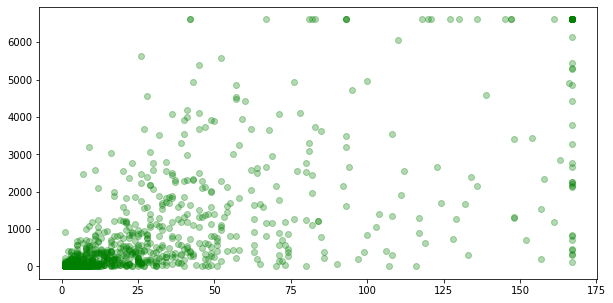

In [173]:
fig = plt.figure(figsize=(10, 5))

plt.scatter(df_with_pred.loc[df_with_pred.CON_EXP_DIV_TOT_EXP_flag == True, 'contractor_100k_ct'],
           df_with_pred.loc[df_with_pred.CON_EXP_DIV_TOT_EXP_flag == True, 'employee_tot_ct'],
           c='green',
           alpha=.3)

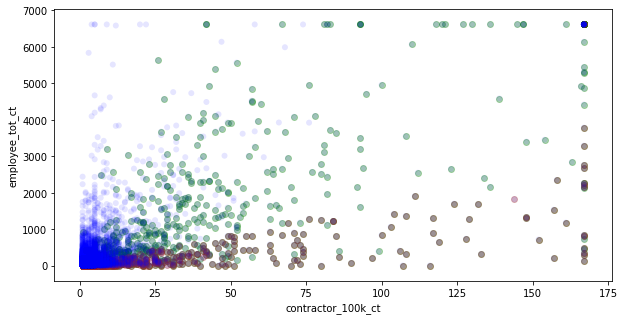

In [187]:
fig = plt.figure(figsize=(10, 5))

plt.scatter(df_with_pred.loc[df_with_pred.CON_EXP_DIV_TOT_EXP_flag == True, 'contractor_100k_ct'],
           df_with_pred.loc[df_with_pred.CON_EXP_DIV_TOT_EXP_flag == True, 'employee_tot_ct'],
           c='green',
           alpha=.3)

plt.scatter(df_with_pred.loc[df_with_pred.CON_CT_DIV_EMP_VOL_CT_flag == True, 'contractor_100k_ct'],
           df_with_pred.loc[df_with_pred.CON_CT_DIV_EMP_VOL_CT_flag == True, 'employee_tot_ct'],
           c='brown',
           alpha=.3)

sns.scatterplot(df_with_pred.contractor_100k_ct,
           df_with_pred.employee_tot_ct,
           color='blue',
           alpha=.1,
           edgecolor="none");

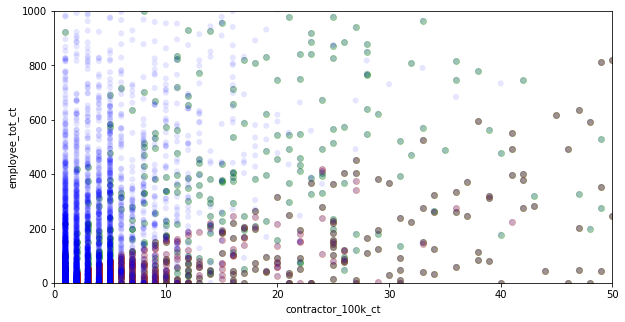

In [188]:
fig = plt.figure(figsize=(10, 5))

plt.scatter(df_with_pred.loc[df_with_pred.CON_EXP_DIV_TOT_EXP_flag == True, 'contractor_100k_ct'],
           df_with_pred.loc[df_with_pred.CON_EXP_DIV_TOT_EXP_flag == True, 'employee_tot_ct'],
           c='green',
           alpha=.3)

plt.scatter(df_with_pred.loc[df_with_pred.CON_CT_DIV_EMP_VOL_CT_flag == True, 'contractor_100k_ct'],
           df_with_pred.loc[df_with_pred.CON_CT_DIV_EMP_VOL_CT_flag == True, 'employee_tot_ct'],
           c='brown',
           alpha=.3)

sns.scatterplot(df_with_pred.contractor_100k_ct,
           df_with_pred.employee_tot_ct,
           color='blue',
           alpha=.1,
           edgecolor="none")

plt.xlim(0, 50)
plt.ylim(0, 1000);

Text(0.5, 0, 'Count of Contractors Paid Over $100K')

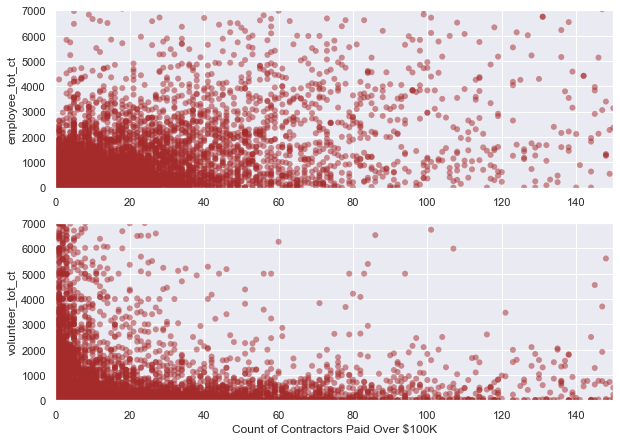

In [436]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df.loc[:,'employee_tot_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
#     plt.title(column)
    ax = sns.scatterplot(df.contractor_100k_ct, df[column], color='brown', alpha=.5, edgecolor="none");
    ax.set_ylabel(column)    
    ax.set_xlabel('')
    plt.xlim(0, 150)
    plt.ylim(0, 7000)
ax.set_xlabel('Count of Contractors Paid Over $100K')

In [71]:
clf.fit(df[['rev_PCA', 'exp_PCA']], y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=950,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

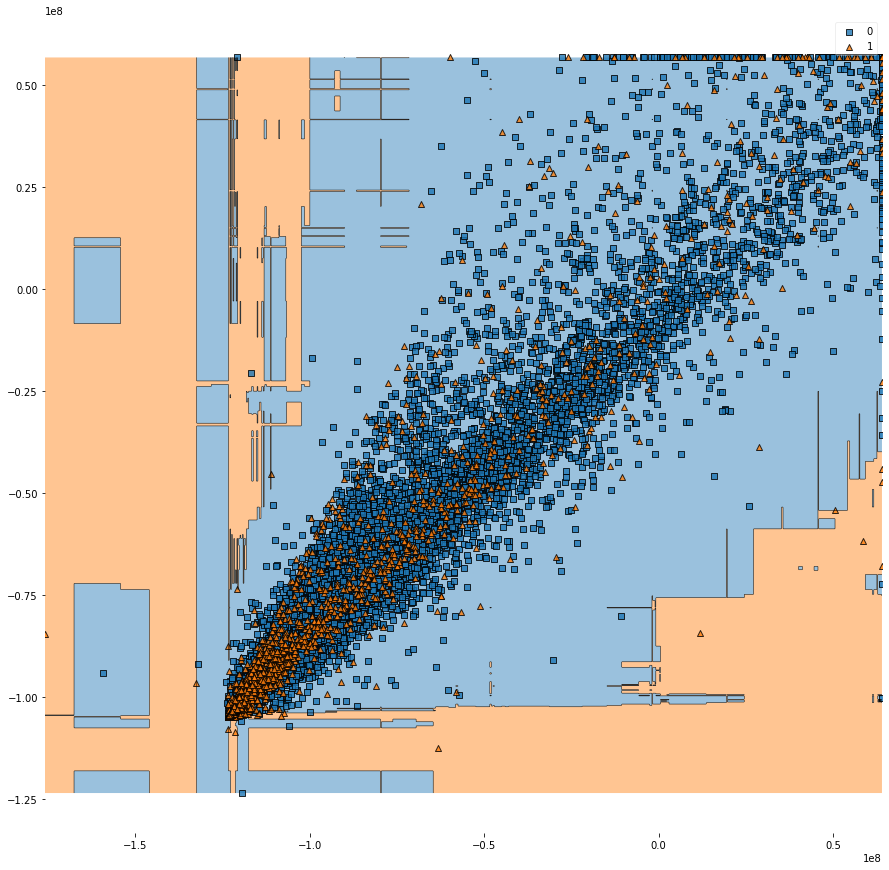

In [73]:
plt.figure(figsize=(15, 15))

plot_decision_regions(np.array(df[['rev_PCA', 'exp_PCA']], dtype = np.float64)
                      ,np.array(y, dtype = np.integer), 
                      clf=clf, legend=2)